In [183]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

# Step 1: load data and cut off regions with missing data:

In [184]:
d = pd.read_csv(
    "data/tageswerte_KL_02932_19340101_20221231_hist/produkt_klima_tag_19340101_20221231_02932.txt",
    sep=";",
    skipinitialspace=True,
)

In [185]:
data = xr.DataArray(d["TMK"], coords={"time": d["MESS_DATUM"]})

In [187]:
data["time"] = pd.to_datetime(data.time, format="%Y%m%d")
data = data.sel(time=slice(np.datetime64("1970-01-01"), None))

# What does the data look like?

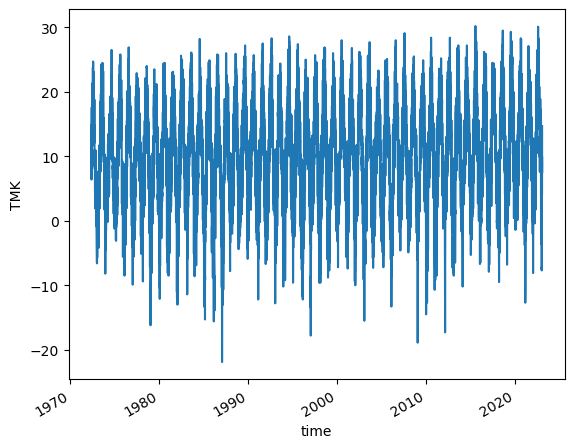

In [188]:
data.plot()
plt.show()

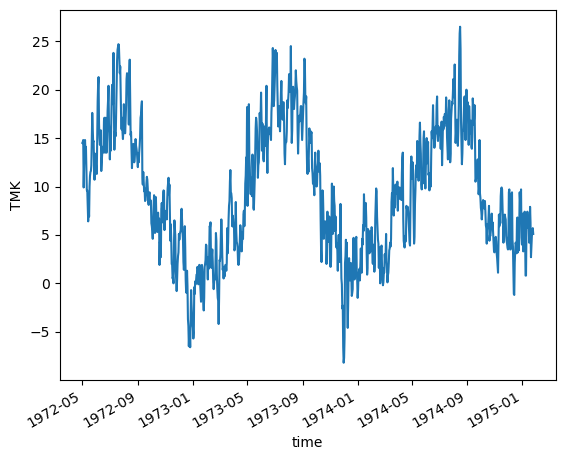

In [189]:
data.isel(time=slice(None, 1000)).plot()
plt.show()

annual cycle:

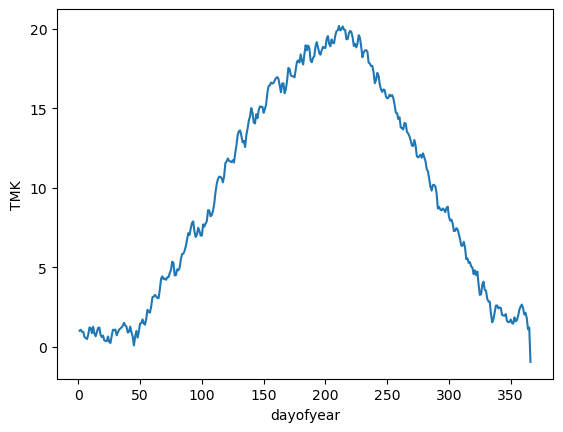

In [193]:
data.groupby("time.dayofyear").mean().plot()
plt.show()

# Climate Change?

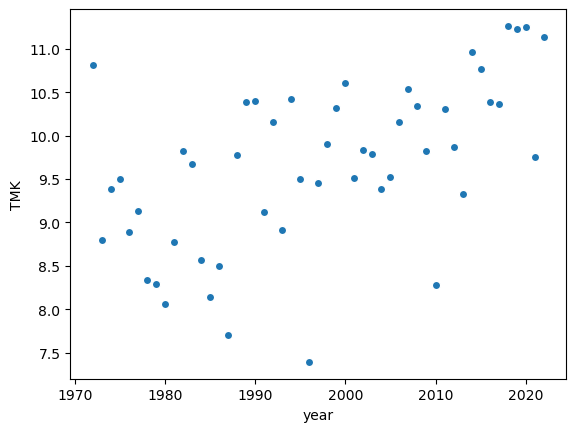

In [79]:
yearly_averages = data.groupby("time.year").mean()

yearly_averages.plot.scatter()
plt.show()

# fit linear trend:

In [80]:
from scipy import optimize


def f(x, m, b):
    return m * x + b

In [81]:
popt, pcov = optimize.curve_fit(f, yearly_averages.year, yearly_averages)
print("Optimal Parameters:", popt)

Optimal Parameters: [ 3.64042699e-02 -6.30406539e+01]


In [82]:
pcov

array([[ 5.79798820e-05, -1.15785824e-01],
       [-1.15785824e-01,  2.31236853e+02]])

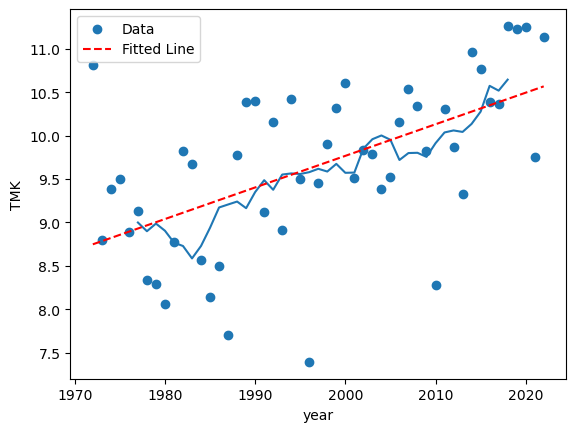

In [85]:
x = yearly_averages.year
y = yearly_averages

plt.scatter(x, y, label="Data")
plt.plot(
    [min(x), max(x)], [f(min(x), *popt), f(max(x), *popt)], "r--", label="Fitted Line"
)
plt.legend()
plt.show()

yearly_averages.rolling(year=10, center=True).mean().plot()

# Exercise sheet

Compute and plot the autocorrelation function (= the autocovariance function normalized by the variance) of the temperature and precipitation time series.

first need to de-trend and deseasonalize data.

In [86]:
from statsmodels.tsa.stattools import acf

In [87]:
climatology = data.rolling(time=15, center=True).mean().groupby("time.dayofyear").mean()

In [101]:
anomaly = (data.groupby("time.dayofyear") - climatology).unstack()

In [124]:
days_since_start = (anomaly.time - anomaly.time[0]) / np.timedelta64(1, "D")

# linear detrending:

In [113]:
popt, pcov = optimize.curve_fit(f, days_since_start, anomaly.values)

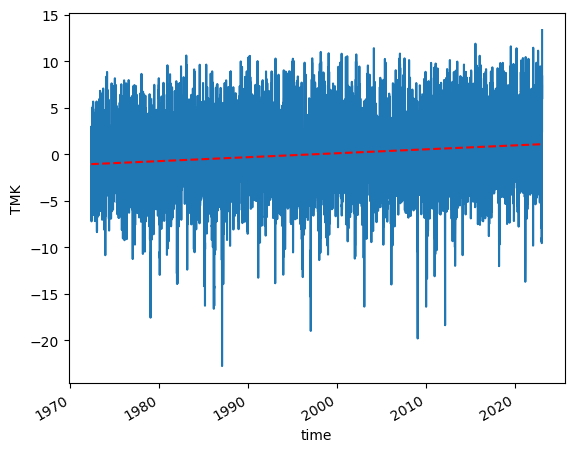

In [131]:
anomaly.plot(label="Data")

plt.plot(
    anomaly.time.isel(time=[0, -1]),
    [f(days_since_start[0], *popt), f(days_since_start[-1], *popt)],
    "r--",
    label="Fitted Line",
)
plt.show()

In [132]:
detrended_anomaly = anomaly - f(
    (anomaly.time - anomaly.time[0]) / np.timedelta64(1, "D"), *popt
)

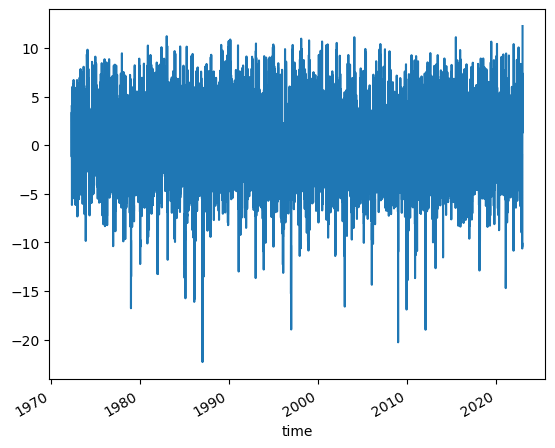

In [133]:
detrended_anomaly.plot()
plt.show()

In [134]:
auto_correlation = acf(detrended_anomaly, missing="raise", nlags=100)

In [136]:
def exponential_decay(x, a, b):
    return a * np.exp(-b * x)

In [140]:
lags = np.arange(len(auto_correlation))
popt, pcov = optimize.curve_fit(exponential_decay, lags, auto_correlation)
print("Optimal Parameters:", popt)

Optimal Parameters: [0.96527743 0.21371375]


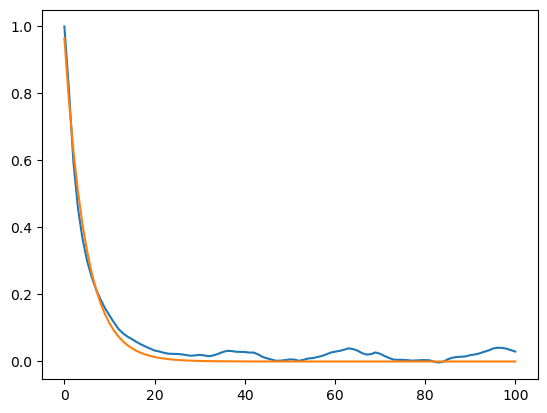

In [141]:
plt.plot(auto_correlation)
plt.plot(lags, exponential_decay(lags, *popt))
plt.show()

From this we can derive (without error bounds) estimates for $\tilde{\sigma}^2$ and $\alpha$:

In [148]:
alpha = np.exp(-popt[1])
sigma_tilde = popt[0] * (1 - alpha**2)
print("alpha:", alpha)
print("sigma_tilde:", sigma_tilde)

alpha: 0.807579523251093
sigma_tilde: 0.3357382724611417


# Power spectral density

In [151]:
from scipy.signal import periodogram

In [169]:
power_spectrum_detrended_deseasonalised = periodogram(detrended_anomaly)

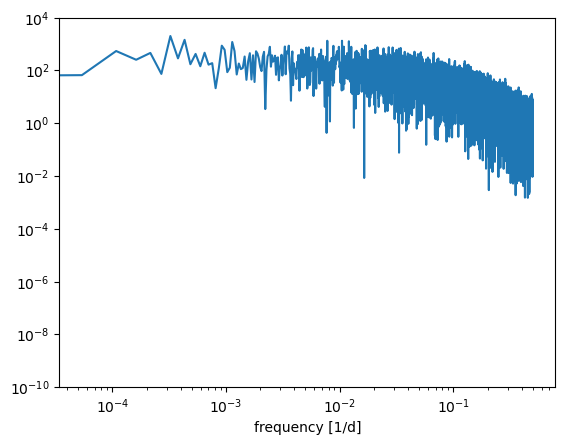

In [170]:
plt.plot(*power_spectrum_detrended_deseasonalised)
plt.ylim([10**-10, 10**4])
plt.xscale("log")
plt.yscale("log")
plt.xlabel("frequency [1/d]")
plt.show()

In [171]:
power_spectrum = periodogram(data)

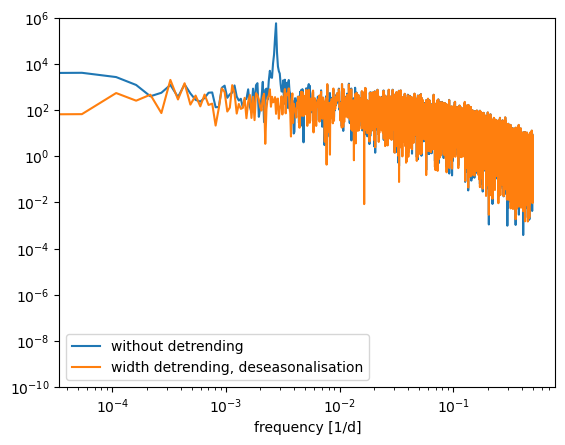

In [176]:
plt.plot(*power_spectrum, label="without detrending")
plt.plot(
    *power_spectrum_detrended_deseasonalised,
    label="width detrending, deseasonalisation",
)
plt.ylim([10**-10, 10**6])
plt.xscale("log")
plt.yscale("log")
plt.xlabel("frequency [1/d]")
plt.legend()
plt.show()